In [1]:
!python -V

Python 3.11.8


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error, root_mean_squared_error

In [4]:
import pickle

In [5]:
## Q1. Downloading the data

df = pd.read_parquet('./data/yellow_tripdata_2023-01.parquet')
print('dtypes', len(df.dtypes))
print(df.dtypes)
df

dtypes 19
VendorID                          int64
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
dtype: object


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.30,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.90,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.90,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.10,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.40,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066761,2,2023-01-31 23:58:34,2023-02-01 00:12:33,NaN,3.05,NaN,None,107,48,0,15.80,0.00,0.5,3.96,0.0,1.0,23.76,NaN,NaN
3066762,2,2023-01-31 23:31:09,2023-01-31 23:50:36,NaN,5.80,NaN,None,112,75,0,22.43,0.00,0.5,2.64,0.0,1.0,29.07,NaN,NaN
3066763,2,2023-01-31 23:01:05,2023-01-31 23:25:36,NaN,4.67,NaN,None,114,239,0,17.61,0.00,0.5,5.32,0.0,1.0,26.93,NaN,NaN
3066764,2,2023-01-31 23:40:00,2023-01-31 23:53:00,NaN,3.15,NaN,None,230,79,0,18.15,0.00,0.5,4.43,0.0,1.0,26.58,NaN,NaN


In [6]:
## Q2. Computing duration

df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
# recalc to minutes
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60) 
# standard deviation
print(df.duration.std())

42.59435124195458


In [7]:
## Q3. Dropping outliers

# what are the majority of values?
print(df.duration.describe(percentiles=[0.95,0.98,0.99]))
# remove outliers
rows_full = df.shape[0]
duration_full = df.duration.copy()
df = df[(df.duration >= 1) & (df.duration <= 60)]
print(f'reduced part = {df.shape[0]/rows_full*100:05.2f}% of full dataset')

count    3.066766e+06
mean     1.566900e+01
std      4.259435e+01
min     -2.920000e+01
50%      1.151667e+01
95%      3.646667e+01
98%      4.873333e+01
99%      5.725000e+01
max      1.002918e+04
Name: duration, dtype: float64
reduced part = 98.12% of full dataset


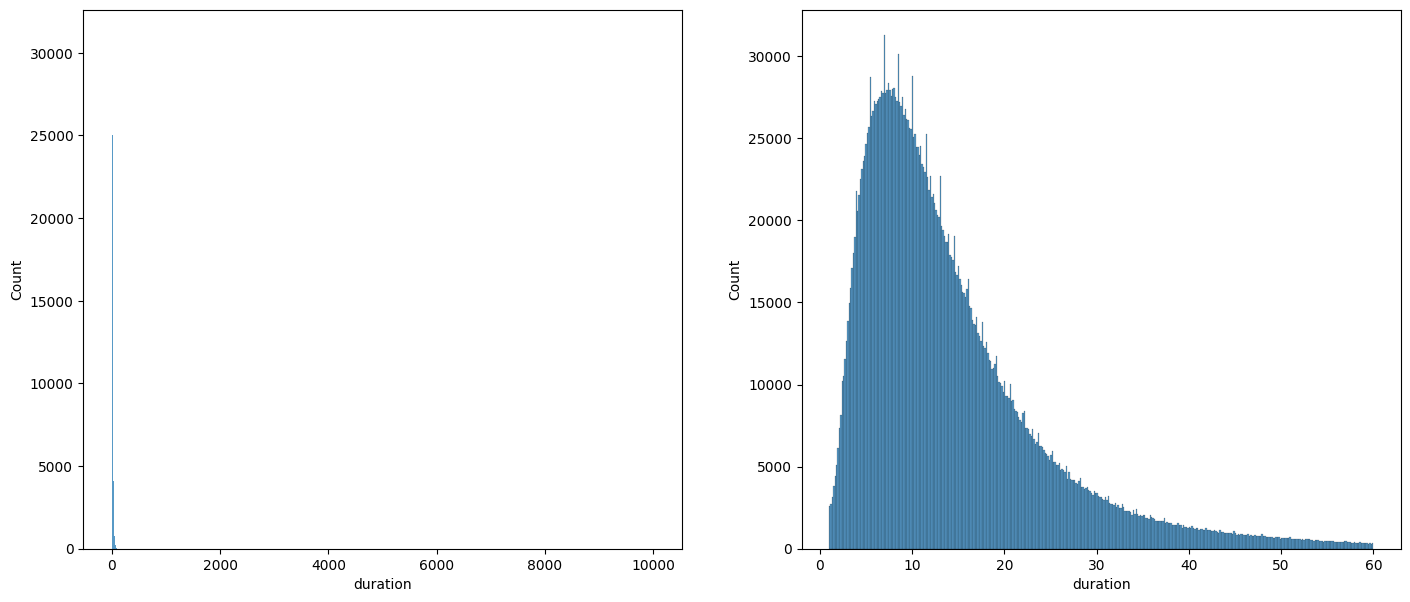

In [8]:
# compare full and reduced visually
fig, ax = plt.subplots(1,2, figsize=(17,7))
plot1 = sns.histplot(duration_full, ax=ax[0])
plot2 = sns.histplot(df.duration, ax=ax[1])
plt.show()

In [9]:
## Q4. One-hot encoding
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

print('The dimensionality of sparce matrix (number of columns) =', X_train.shape[1])

/tmp/ipykernel_443413/202614003.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)


The dimensionality of sparce matrix (number of columns) = 516


In [11]:
## Q5. Training a model

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

# mean_squared_error(y_train, y_pred, squared=False)
root_mean_squared_error(y_train, y_pred)

7.656752078217351

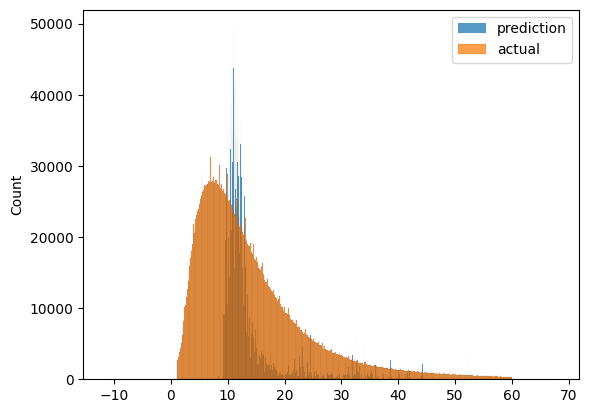

In [12]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='actual')

plt.legend()

In [13]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [14]:
df_train = read_dataframe('./data/yellow_tripdata_2023-01.parquet')
df_val = read_dataframe('./data/yellow_tripdata_2023-02.parquet')

In [15]:
len(df_train), len(df_val)

(3009173, 2855951)

In [16]:
## Q6. Evaluating the model

y_val = df_val[target].values

In [17]:
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

print('The dimensionality of sparce matrix (number of columns) =', X_val.shape[1])

The dimensionality of sparce matrix (number of columns) = 516


In [18]:
y_pred = lr.predict(X_val)
# mean_squared_error(y_val, y_pred, squared=False)
root_mean_squared_error(y_val, y_pred)

7.8186217850321595

In [20]:
# Extra!
# testing different One-hot encoding 
df_train = read_dataframe('./data/yellow_tripdata_2023-01.parquet')
df_val = read_dataframe('./data/yellow_tripdata_2023-02.parquet')

df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [21]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

print('The dimensionality of sparce matrix (number of columns) =', X_train.shape[1])


The dimensionality of sparce matrix (number of columns) = 21802


In [22]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [23]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

# mean_squared_error(y_val, y_pred, squared=False)
root_mean_squared_error(y_val, y_pred)

5.256161852140748

In [25]:
# results with this encoding are better
# 7.8186217850321595 vs 5.256161852140748

In [ ]:
# export trained model
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [24]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

# mean_squared_error(y_val, y_pred, squared=False)
root_mean_squared_error(y_val, y_pred)

9.395699095576239

In [ ]:
# Lasso(0.01) are worse and MUUUCH SLOWER

In [28]:
lr = Ridge(0.001)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

# mean_squared_error(y_val, y_pred, squared=False)
root_mean_squared_error(y_val, y_pred)

5.210748424005898

In [ ]:
# Ridge(0.001) is slightly better and fast 5.210748424005898 vs 5.256161852140748